In [93]:
import tensorflow as tf

In [94]:
import pandas as pd
import numpy as np
from google.cloud import bigquery

In [95]:
%load_ext google.cloud.bigquery
client = bigquery.Client()

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [96]:
sql = """SELECT * from covid19_open_data.covid19_open_data where location_key=country_code"""

In [97]:
df = client.query(sql).to_dataframe()

In [98]:
# from pandas import ExcelWriter
# cur_dir = %pwd
# data_path = cur_dir + '/data'
# writer = ExcelWriter(data_path + "/" + "predictor.xlsx")
# df.to_excel(writer, sheet_name='Sheet1')
# writer.save()

In [99]:
df_US = df[df['location_key'] == 'US']

In [100]:
df_US_sim = df_US.drop(columns=['subregion1_code','subregion1_name','subregion2_code','subregion2_name','iso_3166_1_alpha_2','iso_3166_1_alpha_3',
                               'datacommons_id','openstreetmap_id','rainfall_mm','snowfall_mm','mobility_parks','mobility_residential','mobility_workplaces','wikidata_id',
                               'location_geometry','current_intensive_care_patients','current_ventilator_patients','mobility_transit_stations','mobility_retail_and_recreation',
                               'mobility_grocery_and_pharmacy','new_ventilator_patients','cumulative_hospitalized_patients','cumulative_intensive_care_patients',
                               'cumulative_ventilator_patients','current_hospitalized_patients'])

# Visualizations

In [101]:
# pip install plotly

In [102]:
import plotly  
import plotly.graph_objs as go
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

In [103]:
df_US_sim['daily_change'] = df_US_sim.new_confirmed.pct_change()
round(df_US_sim['daily_change'], 2).quantile(0.05)

-0.31

In [104]:
# print(test_lst)
test_lst = list(df_US_sim['daily_change'])
new_test_lst = []
for items in test_lst:
    if items == float('nan') or items == float('inf'):
        new_test_lst.append(0.0)
    else:
        new_test_lst.append(items)
df_US_sim['daily_change'] = new_test_lst
df_US_sim['daily_change'] = df_US_sim['daily_change'].fillna(0.0)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<Figure size 432x288 with 0 Axes>

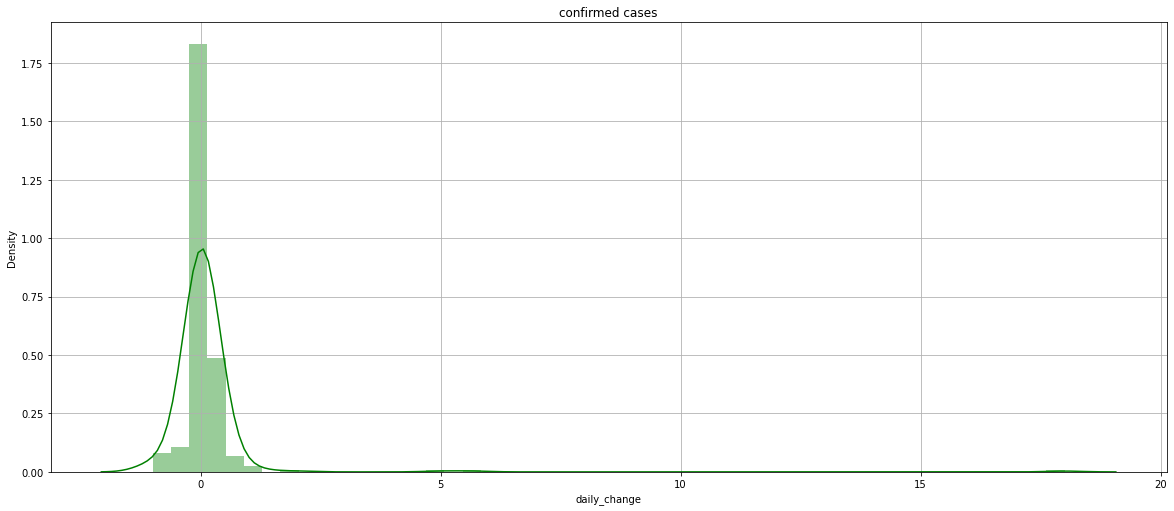

In [105]:
sns.despine(left=True)

#plot a simple histogram with binsize determined automatically
# plt.Figure(figsize=(20,10))
a4_dims = (20, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(df_US_sim['daily_change'], color="green")
plt.title('confirmed cases')
plt.grid(True)
plt.show()

### With 95% confidence, the daily increase in Covid cases will not exceed 31% of the previous day's confirmed cases

### If we have 10,000 cases today, our one-day 31% VaR is 0.31 * 10,000 = 3100

In [106]:
df_US_sim_ind = df_US_sim.set_index('date')

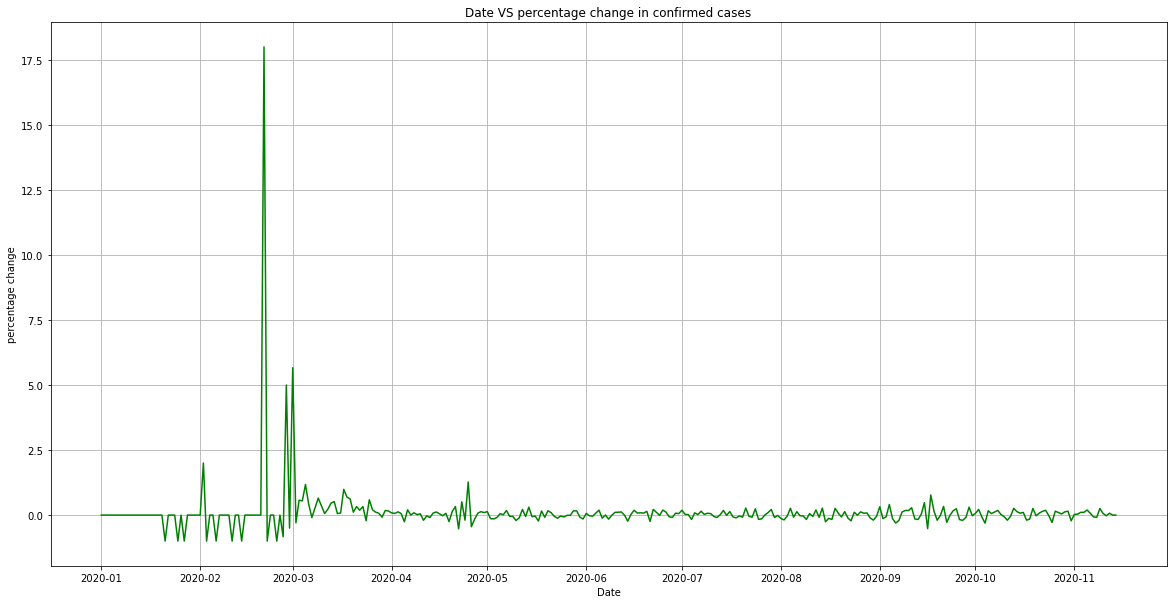

In [107]:
df_US_sim_ind['daily_change'].plot(figsize = (20, 10), color="green", grid = True)
plt.xlabel("Date")
plt.ylabel("percentage change")
plt.title("Date VS percentage change in confirmed cases")
plt.show()

# Feature Engineering
## Adding Weeks, Months and Year Columns

In [108]:
df_US_sim_ind.index = pd.to_datetime(df_US_sim_ind.index, errors='coerce')

In [109]:
# df_US_sim_ind

In [110]:
df_US_sim_ind['day_of_week'] = df_US_sim_ind.index.dayofweek
df_US_sim_ind['day_of_month'] = df_US_sim_ind.index.day
df_US_sim_ind['quarter'] = df_US_sim_ind.index.quarter
df_US_sim_ind['month'] = df_US_sim_ind.index.month
df_US_sim_ind['year'] = df_US_sim_ind.index.year
# df_US_sim_ind

## Adding Summary of the values at previous Time Steps

In [111]:
width = 3
shifted = df_US_sim_ind['new_confirmed'].shift(width - 1)
roll_window = shifted.rolling(window=width)
df_US_sim_ind['min'] = roll_window.min()
df_US_sim_ind['mean'] = roll_window.mean()
df_US_sim_ind['max'] = roll_window.max()
# df_US_sim_ind

In [112]:
df_pred = df_US_sim_ind.copy()
# df_pred

In [113]:
# df_pred = df_US_sim_ind.copy()
# variable for predicting 'n' days out into the future
n = int(30)
future_pred = n
df_pred = df_pred[:-2]
# Create another column (the target/ dependent variable) shifted 'n' units up
df_pred['prediction'] = df_pred['cumulative_confirmed'].shift(-future_pred)
# df_pred['prediction'] = df_pred['new_confirmed']
# df_pred = df_pred.dropna(inplace=True)
# df_pred.head()

In [114]:
df_pred = df_pred.drop(columns=['cumulative_recovered', 'new_recovered'])

In [115]:
df_pred = df_pred.fillna(0)
# df_pred[300:]

In [116]:
df_pred.columns

Index(['location_key', 'country_code', 'country_name', 'aggregation_level',
       'new_confirmed', 'new_deceased', 'new_tested', 'cumulative_confirmed',
       'cumulative_deceased', 'cumulative_tested', 'new_hospitalized_patients',
       'new_intensive_care_patients', 'latitude', 'longitude',
       'average_temperature_celsius', 'minimum_temperature_celsius',
       'maximum_temperature_celsius', 'daily_change', 'day_of_week',
       'day_of_month', 'quarter', 'month', 'year', 'min', 'mean', 'max',
       'prediction'],
      dtype='object')

In [117]:
X = np.array(df_pred.drop(columns = ['location_key','country_code','country_name','aggregation_level'
                                    ,'new_deceased','cumulative_confirmed','cumulative_deceased','cumulative_tested'
                                    ,'latitude', 'longitude','minimum_temperature_celsius',
                                   'maximum_temperature_celsius', 'daily_change', 'day_of_week',
                                   'day_of_month', 'quarter', 'month', 'year', 'min', 'mean', 'max',
                                   'prediction'],axis=1))

In [118]:
X.shape

(317, 5)

In [119]:
X_forecast = X[-future_pred:]
X = X[:-future_pred]
y = np.array(df_pred['prediction'])
y = y[:-future_pred]

In [120]:
X.shape

(287, 5)

In [121]:
from sklearn.model_selection   import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("Time series length: ",len(X_train))
print("Number of time series: ", len(X_train[0,1:]))

Time series length:  200
Number of time series:  4


# Time-Series Cross Validation (tscv)

In [122]:
# pip install tscv

In [123]:
import tscv as cv

In [124]:
cv = cv.GapKFold(n_splits=2, gap_before=1, gap_after=1)
# for train, test in cv.split(range(10)):
#     print("train: ", X_train, "test: ", X_test)

train:  [[ 2.5508000e+04  3.6160800e+05  0.0000000e+00  0.0000000e+00
   1.8271605e+01]
 [ 1.8822000e+04  5.5745700e+05  0.0000000e+00  0.0000000e+00
   2.8160494e+01]
 [ 5.4442000e+04  6.1919600e+05  0.0000000e+00  0.0000000e+00
   2.4808642e+01]
 [ 4.5221000e+04  5.2663100e+05  0.0000000e+00  0.0000000e+00
   2.5802469e+01]
 [ 3.2425000e+04  1.4730200e+05  0.0000000e+00  0.0000000e+00
  -2.5185190e+00]
 [ 2.2048000e+04  4.4101700e+05  0.0000000e+00  0.0000000e+00
   6.7716050e+00]
 [ 6.7717000e+04  1.0111480e+06  0.0000000e+00  0.0000000e+00
   2.1987654e+01]
 [ 2.3297000e+04  3.7685800e+05  0.0000000e+00  0.0000000e+00
   2.0086420e+01]
 [ 1.3963000e+04  1.2555700e+05  0.0000000e+00  0.0000000e+00
   1.3790123e+01]
 [ 5.1100000e+02  1.2495000e+04  0.0000000e+00  0.0000000e+00
   2.7592590e+00]
 [ 1.8695000e+04  1.2080200e+05  0.0000000e+00  0.0000000e+00
   7.9814810e+00]
 [ 8.7890000e+03  1.1134200e+05  0.0000000e+00  0.0000000e+00
   1.0820988e+01]
 [ 0.0000000e+00  0.0000000e+00 

In [125]:
# pip install xgboost

In [126]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [127]:
reg = xgb.XGBRegressor(objective = 'reg:squarederror', n_jobs=-1)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [128]:
confidence = reg.score(X_test, y_test)
print("Confidence %: ", round(confidence*100,2))
print('\n')
prediction = reg.predict(X_forecast)
print('\033[4mExpected confirmed cases for next 30 days\033[0m')
prediction = prediction
print(prediction)
print('\n')

rmse = np.sqrt(mean_squared_error(y_test[:future_pred], prediction[:future_pred]))
print('Test RMSE: %.3f' % rmse)
print('\n')
model_scores = []
model_scores.append(rmse)

Confidence %:  88.08


Expected confirmed cases for next 30 days
[7922250.5 8088293.  6104540.  7960795.  7130245.5 7260808.  7321814.5
 7321020.5 7330482.5 6918062.  6934540.  6410521.5 7151430.5 7346183.
 7310512.5 7267915.  7098668.5 6705078.5 6318265.  7098668.5 8295732.5
 8645248.  8423674.  8284780.5 7714878.5 7719507.5 3793537.8 1267838.9
 1265558.9 1265558.9]


Test RMSE: 4990474.179




In [129]:
from sklearn import linear_model as lm
reg1 = lm.LinearRegression()
reg1.fit(X_train, y_train)

LinearRegression()

In [130]:
confidence1 = reg1.score(X_test, y_test)
print("Confidence %: ", round(confidence1*100,2))
print('\n')
prediction1 = reg1.predict(X_forecast)
print('\033[4mExpected confirmed cases for next 30 days\033[0m')
print(prediction1)
print('\n')

rmse1 = np.sqrt(mean_squared_error(y_test[:future_pred], prediction1[:future_pred]))
print('Test RMSE: %.3f' % rmse1)
print('\n')
model_scores.append(rmse)

Confidence %:  82.3


Expected confirmed cases for next 30 days
[ 9052962.14590961  9642924.56941371  8384379.68256113  5883918.37477427
  6533778.47882769  9120787.16035877 10406419.78711013 10951156.44238148
 10743419.61157595  9126634.66167155  6713344.91222877  7372530.67587254
  9872303.73269618 10818125.35536565 10846860.92010655 11187401.72813216
  9529571.24062419  7172980.43506252  7800453.29136331  9309830.62990746
 10572261.37714956 10610388.39387117 10274748.41649495  9463149.3083419
  6857076.1918714   6430912.18265556  5201444.57753591  2112620.34805278
  2077384.98936033  2207801.19374966]


Test RMSE: 6496938.768




In [131]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=4, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, random_state=0)

In [132]:
confidence3 = regr.score(X_test, y_test)
print("Confidence %: ", round(confidence3*100,2))
print('\n')
prediction3 = regr.predict(X_forecast)
print('\033[4mExpected confirmed cases for next 30 days\033[0m')
print(prediction3)
print('\n')

rmse3 = np.sqrt(mean_squared_error(y_test[:future_pred], prediction3[:future_pred]))
print('Test RMSE: %.3f' % rmse3)
print('\n')
model_scores.append(rmse)

Confidence %:  92.08


Expected confirmed cases for next 30 days
[8653175.6855682  8539216.14909092 8074447.45775677 8275466.53095519
 8377568.02911072 8534122.46509726 8549533.25734726 8457076.82861998
 8450066.74861998 8258337.81435943 7959596.43301726 8001404.24842192
 8434655.95636998 8450066.74861998 8450066.74861998 8450066.74861998
 8449350.08636999 7993531.18583158 7938175.58972691 8449350.08636999
 8570191.60075759 8586711.19337664 8571300.40112664 8375791.76341979
 8048762.41330464 8097825.69309036 3057127.95085853 1028048.97290656
 1028048.97290656 1028048.97290656]


Test RMSE: 5802232.610




In [133]:
y_test_list = []
for i in y_test[:future_pred]:
    y_test_list.append(float(i))
print(y_test_list)

[1851520.0, 6896274.0, 4495014.0, 3902058.0, 5573847.0, 15.0, 3830010.0, 124665.0, 6201726.0, 2048986.0, 15.0, 1309541.0, 554.0, 2137731.0, 2510323.0, 2114026.0, 7115046.0, 939053.0, 1577287.0, 2255119.0, 11.0, 6397227.0, 1443397.0, 2686480.0, 398809.0, 1721750.0, 8214755.0, 988451.0, 55231.0, 1133069.0]


In [134]:
df_US_sim_ARM = df_US_sim[['date','cumulative_confirmed']]

In [135]:
df_US_sim_ARM = df_US_sim_ARM[:-2]
# df_US_sim_ARM

## Holts

In [136]:
# pip install fbprophet

In [137]:
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures

In [138]:
valid_set = df_US_sim_ARM[-30:]
train_set = df_US_sim_ARM[:-30]
begin_date = '2020-11-09'
df_date = pd.DataFrame({'cumulative_confirmed':0, 
                      'date':pd.date_range(begin_date, periods=90)})
test_set = valid_set.append(df_date, ignore_index=True)
test_set['date'] = pd.to_datetime(test_set['date'] ,errors = 'coerce',format = '%Y-%m-%d')
test_set = test_set.set_index('date')

In [139]:
# model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
# valid=datewise.iloc[int(datewise.shape[0]*0.95):]
model_train = train_set.set_index('date')  # only training set without last 30 rows
valid = valid_set.set_index('date') # only validation set with only last 30 rows
y_pred=test_set.copy() # validation set + test set with last 30 rows + additional 90 rows/dates

In [140]:
holt=Holt(np.asarray(model_train["cumulative_confirmed"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False) 

In [141]:

y_pred["Holt"]=holt.forecast(len(test_set))
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["Holt"][:valid.shape[0]-1])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["Holt"][:valid.shape[0]-1])))

Root Mean Square Error Holt's Linear Model:  470608.20022813056


In [142]:
# y_pred['Holt'] = y_pred['Holt'].astype(int)

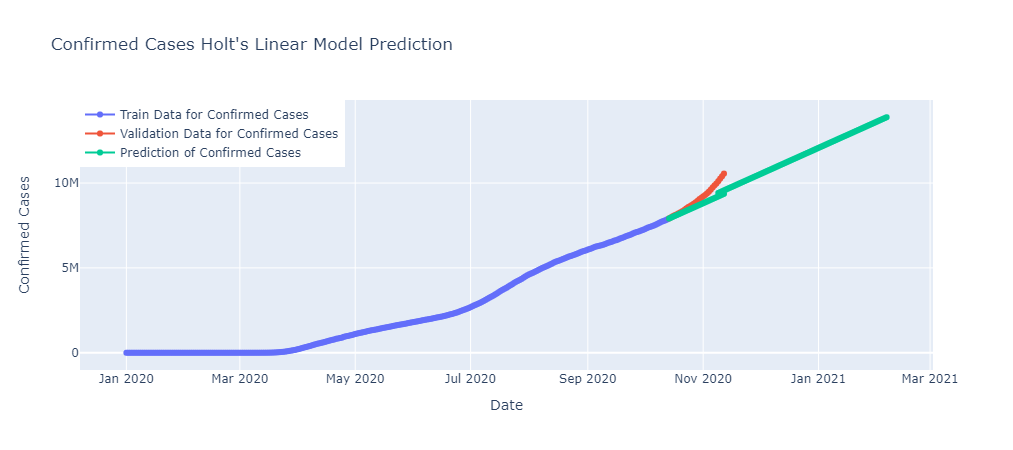

In [143]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### Holt's Winter Model for Daily Time Series

In [144]:
model_train['cumulative_confirmed_winter'] = model_train['cumulative_confirmed'].astype(int)
model_train['cumulative_confirmed_winter'] = model_train['cumulative_confirmed'].abs()
model_train['cumulative_confirmed_winter'] = model_train['cumulative_confirmed'].replace(0,1)

In [145]:
es=ExponentialSmoothing(np.asarray(model_train['cumulative_confirmed_winter']),seasonal_periods=14,trend='add', seasonal='mul').fit()

In [146]:
y_pred["Holt's Winter Model"]=es.forecast(len(test_set))
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["Holt's Winter Model"][:valid.shape[0]-1])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["Holt's Winter Model"][:valid.shape[0]-1])))

Root Mean Square Error for Holt's Winter Model:  436982.2255826876


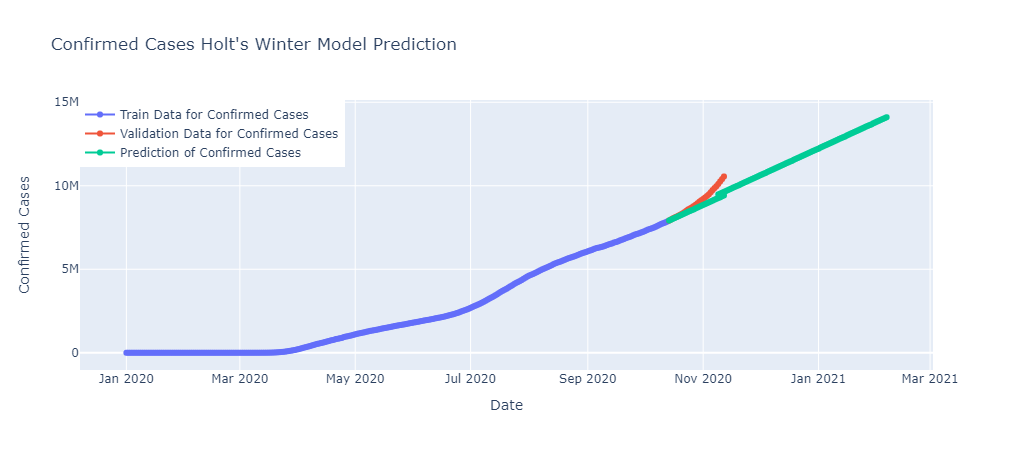

In [147]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed_winter"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["Holt's Winter Model"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [148]:
y_pred["Holt's Winter Model"] = y_pred["Holt's Winter Model"].astype(int)
# y_pred

## AR Model (using AUTO ARIMA)

In [149]:
# conda create -n pmdarima --yes python=3.5 scipy numpy scikit-learn pandas statsmodels

In [150]:
# conda install --yes -c anaconda pyramid

In [151]:
# pip install pmdarima

In [152]:
from pmdarima.arima import auto_arima

In [153]:
model_ar= auto_arima(model_train["cumulative_confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["cumulative_confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5767.843, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5751.314, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=5741.822, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=5727.723, Time=0.08 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=5722.203, Time=0.15 sec
Total fit time: 0.312 seconds


ARIMA(order=(4, 2, 0), scoring_args={}, suppress_warnings=True)

In [154]:
prediction_ar=model_ar.predict(len(test_set))
y_pred["AR Model Prediction"]=prediction_ar

In [155]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["AR Model Prediction"][:valid.shape[0]-1])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["AR Model Prediction"][:valid.shape[0]-1])))

Root Mean Square Error for AR Model:  433899.9197281921


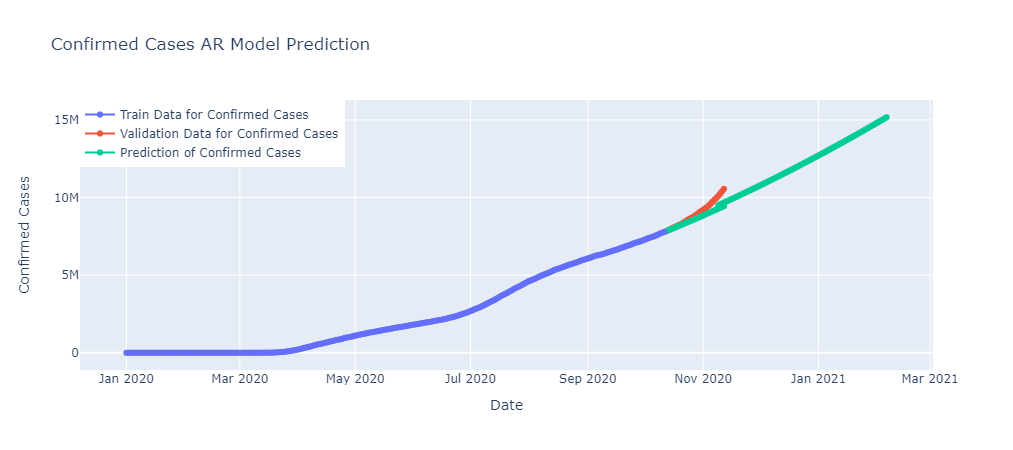

In [156]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### MA Model (using AUTO ARIMA)

In [157]:
model_ma= auto_arima(model_train["cumulative_confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=2,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ma.fit(model_train["cumulative_confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5767.843, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=5729.764, Time=0.23 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=5721.262, Time=0.06 sec
Total fit time: 0.322 seconds


ARIMA(order=(0, 2, 2), scoring_args={}, suppress_warnings=True)

In [158]:
prediction_ma=model_ma.predict(len(test_set))
y_pred["MA Model Prediction"]=prediction_ma

In [159]:
prediction_ma.shape

(120,)

In [160]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],prediction_ma[:valid.shape[0]-1])))
print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],prediction_ma[:valid.shape[0]-1])))

Root Mean Square Error for MA Model:  375795.3870629915


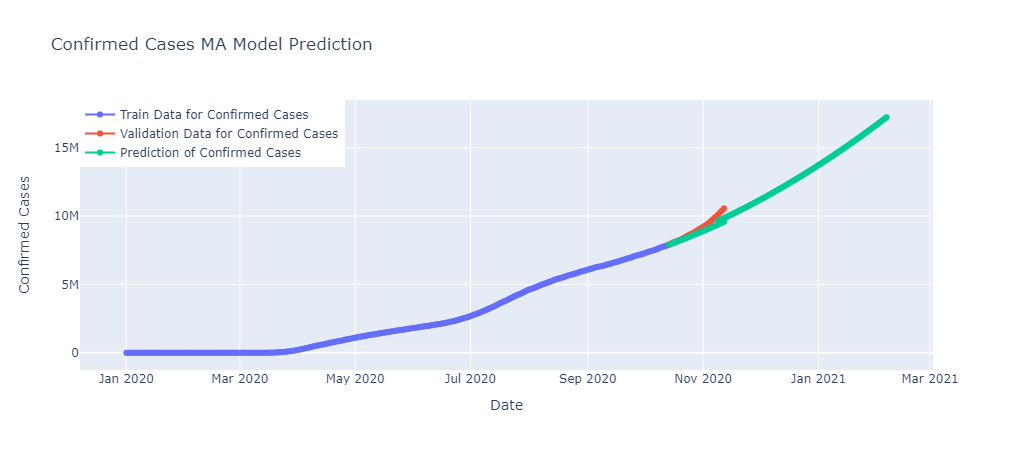

In [161]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["MA Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases MA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### ARIMA Model (using AUTOARIMA)

In [162]:
model_arima= auto_arima(model_train["cumulative_confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["cumulative_confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5767.843, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=5729.764, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=5721.262, Time=0.09 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=5725.001, Time=0.17 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5751.314, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=5717.803, Time=0.22 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=5724.341, Time=0.16 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=5697.940, Time=0.83 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=5741.822, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=5718.243, Time=0.21 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=5720.911, Time=0.70 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=5668.635, Time=0.92 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=5727.723, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=5711.213, Time=0.25 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=5716.710, Time=0.43 sec
Total fit 

ARIMA(order=(2, 2, 3), scoring_args={}, suppress_warnings=True)

In [163]:
prediction_arima=model_arima.predict(len(test_set))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [164]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],prediction_arima[:valid.shape[0]-1])))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],prediction_arima[:valid.shape[0]-1])))

Root Mean Square Error for ARIMA Model:  299246.57291503594


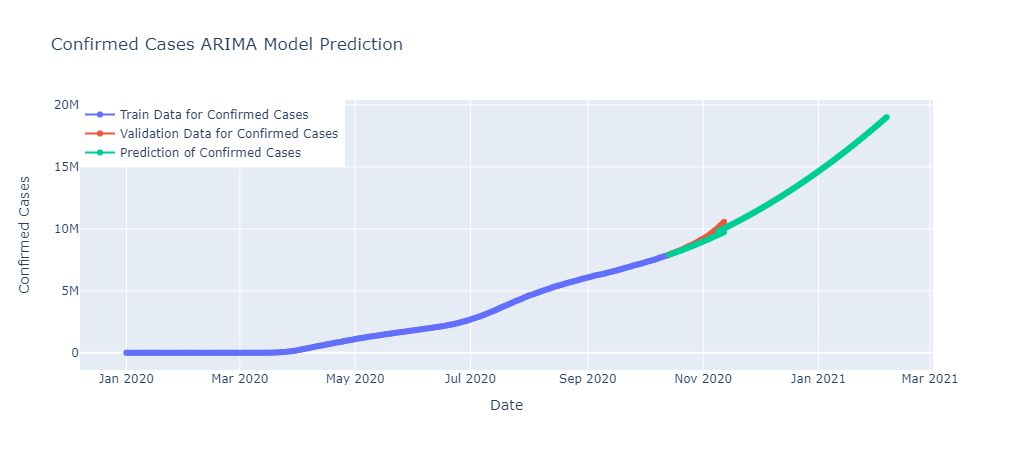

In [165]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### SARIMA Model (using AUTO ARIMA)

In [166]:
model_sarima= auto_arima(model_train["cumulative_confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_sarima.fit(model_train["cumulative_confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5767.843, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=5729.764, Time=0.07 sec


/opt/conda/lib/python3.7/site-packages/pmdarima/arima/_validation.py:60: UserWarning:

m (7) set for non-seasonal fit. Setting to 0



 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=5721.262, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5751.314, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=5717.803, Time=0.24 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=5724.341, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=5741.822, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=5718.243, Time=0.19 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=5720.911, Time=0.64 sec
Total fit time: 1.465 seconds


ARIMA(order=(1, 2, 1), scoring_args={}, suppress_warnings=True)

In [167]:
prediction_sarima=model_sarima.predict(len(test_set))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [168]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["SARIMA Model Prediction"][:valid.shape[0]-1])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["SARIMA Model Prediction"][:valid.shape[0]-1])))

Root Mean Square Error for SARIMA Model:  443934.34104275284


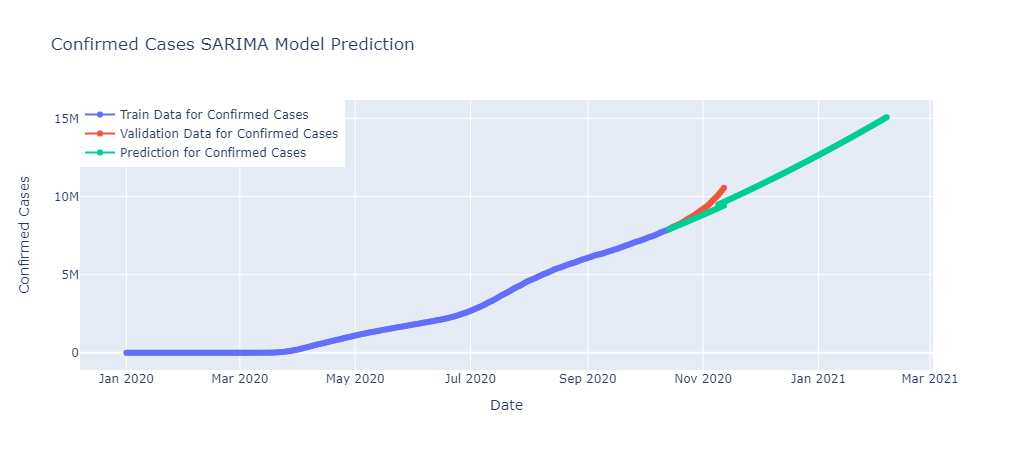

In [169]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### Facebook's Prophet Model for forecasting

In [170]:
df_US_sim_FB = df_US_sim_ARM.set_index('date')

In [171]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(df_US_sim_FB.index),list(df_US_sim_FB["cumulative_confirmed"])),columns=['ds','y'])

In [172]:
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [173]:
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [174]:
confirmed_forecast=prophet_c.predict(forecast_c)

In [175]:
model_scores.append(np.sqrt(mean_squared_error(df_US_sim_FB["cumulative_confirmed"],confirmed_forecast['yhat'].head(df_US_sim_FB.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(df_US_sim_FB["cumulative_confirmed"],confirmed_forecast['yhat'].head(df_US_sim_FB.shape[0]))))

Root Mean Squared Error for Prophet Model:  108158.35128756746


Figure(720x432)


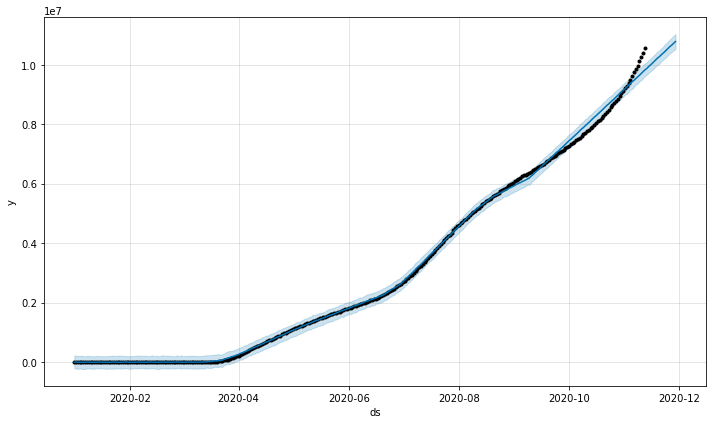

In [176]:
print(prophet_c.plot(confirmed_forecast))

In [177]:
model_scores

[4990474.179499655,
 4990474.179499655,
 4990474.179499655,
 470608.20022813056,
 436982.2255826876,
 433899.9197281921,
 375795.3870629915,
 299246.57291503594,
 443934.34104275284,
 108158.35128756746]

In [178]:
model_names=["XGBoost","Linear Regression","Random Forest Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary['Root Mean Squared Error'] = model_summary['Root Mean Squared Error'].astype(int)
model_summary

,Model Name,Root Mean Squared Error
9,Facebook's Prophet Model,108158
7,ARIMA Model,299246
6,Moving Average Model (MA),375795
5,Auto Regressive Model (AR),433899
4,Holt's Winter Model,436982
8,SARIMA Model,443934
3,Holt's Linear,470608
0,XGBoost,4990474
1,Linear Regression,4990474
2,Random Forest Regressor,4990474


In [179]:
y_pred = y_pred[['cumulative_confirmed','AR Model Prediction','MA Model Prediction','ARIMA Model Prediction','SARIMA Model Prediction']].astype(int)

In [180]:
y_pred

,cumulative_confirmed,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
date,,,,,
2020-10-14,7916100,7909810,7908522,7912519,7907382
2020-10-15,7979885,7961977,7959717,7971128,7957642
2020-10-16,8050141,8011827,8011372,8028710,8007909
2020-10-17,8106752,8061300,8063485,8082797,8058301
2020-10-18,8154595,8112205,8116058,8134027,8108852
...,...,...,...,...,...
2021-02-02,0,14885433,16805122,18480195,14792811
2021-02-03,0,14956417,16909109,18611226,14862698
2021-02-04,0,15027579,17013556,18742344,14932757
